In [45]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.optimize import minimize_scalar
from sympy import Symbol, Derivative, cot
import sympy.solvers
from sympy import init_printing

init_printing(use_latex=True)
x = Symbol('x')

### Метод бисекции 


Скорость сходимости

Особенности

И так далее

In [61]:
def bisection_solve(func, a, b, eps, show_history=False):
    try:
        func.subs(x, a);  
    except AttributeError:
        print('Incorrect type of given function!')
    else:
        f = lambda val: func.subs(x, val)
        
    if a >= b:
        raise ValueError("Inappropriate domain is given: a >= b.")
    if f(a) * f(b) >= 0:
        raise ValueError("Cannot solve such equation with this method: func(a)*func(b)>=0.")
    
    k = 0
    while True:
        x0 = (a + b) / 2
        if show_history:
            display(HTML("a<sub>{ind}</sub> = %.5f,\
            b<sub>{ind}</sub> = %.5f,\
            b<sub>{ind}</sub>-a<sub>{ind}</sub> = %.5f.".format(ind=k) % (a, b, b-a)))
            k = k + 1
        if (b-a)/2 < eps:
            return x0
        if f(a) * f(x0) < 0:
            b = x0
        else:
            a = x0

### Метод хорд 

Отрезок делится не пополам, а в соотношении $\rvert{f(a)}\rvert:\rvert{f(b)}\rvert$

Рассчётная формула: $x_{k+1} = x_k - \frac{f(x_k)}{f(x_k)- f(c)} (x_k - c)$

In [3]:
def chords_method_solve(func, a, b, fixed, eps, show_history=False):
    
    if fixed == 'left':
        c = a
        x_curr = b
    elif fixed == 'right': 
        c = b
        x_curr = a
    else:
        raise ValueError("Inappropriate value for argument 'fixed'!")
    k = 1
    while True:
        x_next = x_curr - func(x_curr) * (x_curr - c) / (func(x_curr) - func(c))
        if show_history:
            print("%2d. x\u2096 = %.5f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
            k = k + 1
        if abs(x_next - x_curr) <= eps:
            return x_next
        x_curr = x_next

### Метод релаксации

In [93]:
def relaxation_method_solve(func, a, b, tau0, eps, show_history=False):
    
    x_curr = (a + b) / 2
    x_next = x_curr + tau0 * func(x_curr)
    if show_history:
        print("%2d. x\u2096 = %.5f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (1, x_next, abs(x_next-x_curr)))
        k = 2
    while np.abs(x_curr - x_next) >= eps:
        x_curr = x_next
        x_next = x_curr + tau0 * func(x_curr)
        if show_history:
            print("%2d. x\u2096 = %.5f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
            k = k + 1
    
    return x_next

### Метод Ньютона 

In [5]:
def newton_method_solve(func, a, b, fixed, eps, show_history=False):
    """func - sympy function"""
    if fixed == 'left':
        x_curr = b
    elif fixed == 'right': 
        x_curr = a
    else:
        raise ValueError("Inappropriate value for argument 'fixed'!")
        
    x_next = float(x_curr - func.subs(x, x_curr) / func.diff(x).subs(x, x_curr))
    if show_history:
        k = 1
        print("%2d. x\u2096 = %.6f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
    while np.abs(x_next - x_curr) >= eps:
        x_curr = x_next
        x_next = float(x_curr - func.subs(x, x_curr) / func.diff(x).subs(x, x_curr))
        if show_history:
            k = k + 1
            print("%2d. x\u2096 = %.6f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
    return x_next

### Комбинированный метод (хорд и Ньютона) 

In [6]:
def combined_chord_newton_solve(func, a, b, newt, eps, show_history=False):
    if newt == 'left':
        x_newt = a - func.subs(x, a) / func.diff(x).subs(x, a)
    elif newt == 'right':
        x_newt = b - func.subs(x, b) / func.diff(x).subs(x, b)
    else:
        raise ValueError("Inappropriate value for argument 'chord'!")    
    x_chord = (a * func.subs(x, b) - b * func.subs(x, a)) / (func.subs(x, b) - func.subs(x, a))
    if show_history:
        k = 0
        print("%2d. x_newt = %.6f, x_chord = %.6f, |x_newt - x_chord| =  %.7f." % (k, x_newt, x_chord, abs(x_newt-x_chord)))
    while True:
        x_chord = float( x_chord - func.subs(x, x_chord) * ( x_newt - x_chord ) /
                        ( func.subs(x, x_newt) - func.subs(x, x_chord) ) )
        x_newt = float( x_newt - func.subs(x, x_newt) / func.diff(x).subs(x, x_newt) )
        if show_history:
            k = k + 1
            print("%2d. x_newt = %.6f, x_chord = %.6f, |x_newt - x_chord| =  %.7f." % (k, x_newt, x_chord, abs(x_newt-x_chord)))
        if np.abs(x_chord - x_newt) <= eps:
            return (x_chord + x_newt) / 2        

### Метод секущих 

In [7]:
def secant_method_solve(func, a, b, fixed, delta, eps, show_history=False):
    if fixed == 'left':
        x_curr = b
    elif fixed == 'right': 
        x_curr = a
    else:
        raise ValueError("Inappropriate value for argument 'fixed'!")
        
    x_next = x_curr - delta / (func(x_curr) - func(x_curr - delta)) * func(x_curr)
    if show_history:
        k = 1
        print("%2d. x\u2096 = %.5f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
        
    while np.abs(x_next - x_curr) >= eps:
        x_prev = x_curr
        x_curr = x_next
        x_next = x_curr - (x_curr - x_prev) / (func(x_curr) - func(x_prev)) * func(x_curr)
        if show_history:
            k = k + 1
            print("%2d. x\u2096 = %.5f, |x\u2096-x\u2096\u208b\u2081| = %.6f." % (k, x_next, abs(x_next-x_curr)))
    
    return x_next    

### Примеры 

#### Полином 3й степени

In [6]:
a0, a1, a2, a3 = 1, -3, 12, -9
P3 = a0* x**3 + a1 * x**2 + a2 * x + a3
P3

<IPython.core.display.Javascript object>


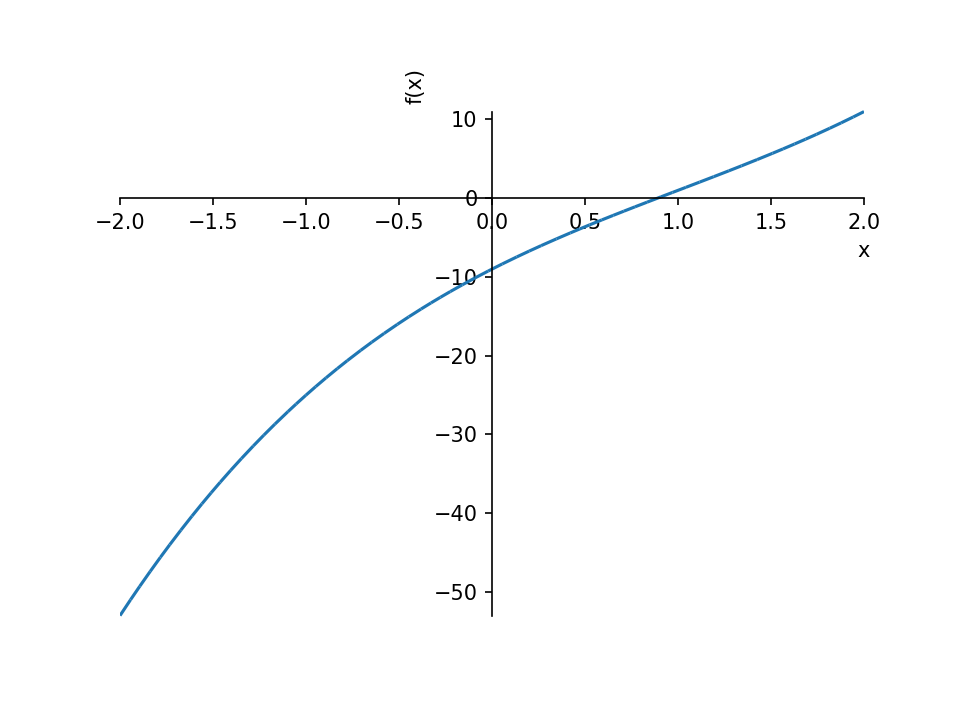

In [9]:
plot = sympy.plot(P3, (x, -2, 2));
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
fig.show('f1.png')

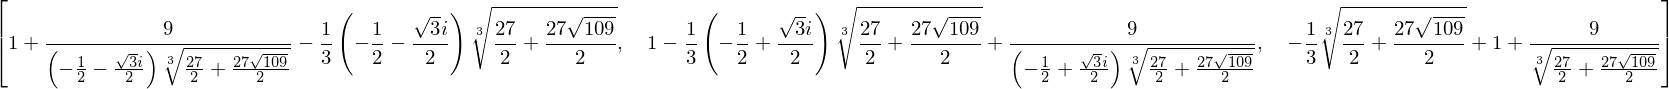

In [123]:
sympy.solve(P3, x)

In [122]:
u1 + v1 + 1

#### Локализация корней 

In [11]:
A = max([a1, a2, a3])
B = max([a0, a1, a2])

r, R = abs(a3) / (B + abs(a3)), 1 + A / abs(a0)
print("{} <= |z| <= {}.".format(r, R))

0.42857142857142855 <= |z| <= 13.0.


In [12]:
# по следствию из теоремы Лагранжа о верхней грани положительных корней
p = []

g1 = (P3.subs(x, 1/x) * x**3).simplify()
g2 = (P3.subs(x, -x)).simplify()
g3 = (P3.subs(x, -1/x) * x**3).simplify()
P3, g1, g2, g3

In [13]:
#p0 = 10
#p1 = ?
# p2 = 0, p3 = 0

In [14]:
# for poly in [P3, g1, g2, g3]:
#     pass

In [15]:
a, b = 0.0, 1.0 
eps = 1e-4

func = lambda val: P3.subs(x, val)

#### Метод бисекции 

In [16]:
x0 = (a + b) / 2
# оценка количества итераций
print(np.log2(1 / (2*eps)))
# 1я итерация
display((func(a), func(x0), func(b)))
# 2я итерация
display((func(x0), func((x0 + b)/2), func(b)))

12.2877123795


In [17]:
x_bis = bisection_solve(func, a, b, eps, show_history=True)
x_bis, func(x_bis)

 0. a = 0.00000, b = 1.00000, b-a = 1.00000.
 1. a = 0.50000, b = 1.00000, b-a = 0.50000.
 2. a = 0.75000, b = 1.00000, b-a = 0.25000.
 3. a = 0.87500, b = 1.00000, b-a = 0.12500.
 4. a = 0.87500, b = 0.93750, b-a = 0.06250.
 5. a = 0.87500, b = 0.90625, b-a = 0.03125.
 6. a = 0.87500, b = 0.89062, b-a = 0.01562.
 7. a = 0.88281, b = 0.89062, b-a = 0.00781.
 8. a = 0.88672, b = 0.89062, b-a = 0.00391.
 9. a = 0.88867, b = 0.89062, b-a = 0.00195.
10. a = 0.88867, b = 0.88965, b-a = 0.00098.
11. a = 0.88867, b = 0.88916, b-a = 0.00049.
12. a = 0.88892, b = 0.88916, b-a = 0.00024.
13. a = 0.88904, b = 0.88916, b-a = 0.00012.


#### Метод хорд

In [18]:
sec_deriv = P3.diff(x, 2)
sec_deriv, sec_deriv.subs(x, a)

In [19]:
x_chords = chords_method_solve(func, a, b, 'left', eps, show_history=True)
x_chords, func(x_chords)

 1. xₖ = 0.90000, |xₖ-xₖ₋₁| = 0.100000.
 2. xₖ = 0.89021, |xₖ-xₖ₋₁| = 0.009792.
 3. xₖ = 0.88917, |xₖ-xₖ₋₁| = 0.001042.
 4. xₖ = 0.88905, |xₖ-xₖ₋₁| = 0.000112.
 5. xₖ = 0.88904, |xₖ-xₖ₋₁| = 0.000012.


#### Метод релаксации

In [20]:
first_div = P3.diff(x)
first_div # f'(x) < 0 на [0; 1], поэтому рассматриваем функцию -f(x)

In [21]:
M1, m1 = 12, 9 # => tau0 = 2/21
func_ = lambda val: -func(val)
x_relax = relaxation_method_solve(func_, a, b, 2/(m1+M1) , eps, show_history=True)
x_relax, func(x_relax)

 1. xₖ = 0.84524, |xₖ-xₖ₋₁| = 0.345238.
 2. xₖ = 0.88301, |xₖ-xₖ₋₁| = 0.037768.
 3. xₖ = 0.88820, |xₖ-xₖ₋₁| = 0.005195.
 4. xₖ = 0.88892, |xₖ-xₖ₋₁| = 0.000723.
 5. xₖ = 0.88902, |xₖ-xₖ₋₁| = 0.000101.
 6. xₖ = 0.88904, |xₖ-xₖ₋₁| = 0.000014.


#### Метод Ньютона

In [22]:
P3.subs(x, a) * sec_deriv.subs(x, a) > 0 # => fixed = 'right'

In [23]:
x_newt = newton_method_solve(P3, a, b, 'right', eps, show_history=True)
x_newt, func(x_newt)

 1. xₖ = 0.750000, |xₖ-xₖ₋₁| = 0.750000.
 2. xₖ = 0.887755, |xₖ-xₖ₋₁| = 0.137755.
 3. xₖ = 0.889041, |xₖ-xₖ₋₁| = 0.001286.
 4. xₖ = 0.889041, |xₖ-xₖ₋₁| = 0.000000.


#### Комбинированный метод (хорд и Ньютона)  

In [24]:
P3.subs(x, a) * sec_deriv.subs(x, a) > 0 # => newt = 'left'

In [25]:
x01 = 0.75
x02 = 0.9
x01 - P3.subs(x, x01) / P3.diff(x).subs(x, x01), x02 - P3.subs(x, x02) / (P3.subs(x, x01) - P3.subs(x, x02)) * (x01 - x02)

In [26]:
x_comb = combined_chord_newton_solve(P3, 0, 1, 'left', 1e-4, show_history=True)
x_comb, func(x_comb)

 0. x_newt = 0.750000, x_chord = 0.900000, |x_newt - x_chord| =  0.1500000.
 1. x_newt = 0.887755, x_chord = 0.889118, |x_newt - x_chord| =  0.0013628.
 2. x_newt = 0.889041, x_chord = 0.889041, |x_newt - x_chord| =  0.0000001.


#### Метод секущих

In [27]:
x_sec = secant_method_solve(func, 0, 1, 'right', 0.1, 1e-4, show_history=True)
x_sec, func(x_sec)

 1. xₖ = 0.73111, |xₖ-xₖ₋₁| = 0.731113.
 2. xₖ = 0.87031, |xₖ-xₖ₋₁| = 0.139193.
 3. xₖ = 0.88888, |xₖ-xₖ₋₁| = 0.018569.
 4. xₖ = 0.88904, |xₖ-xₖ₋₁| = 0.000165.
 5. xₖ = 0.88904, |xₖ-xₖ₋₁| = 0.000000.


#### Неявно заданная функция

$$ctg{x} = - \frac{1}{2x}$$

<IPython.core.display.Javascript object>


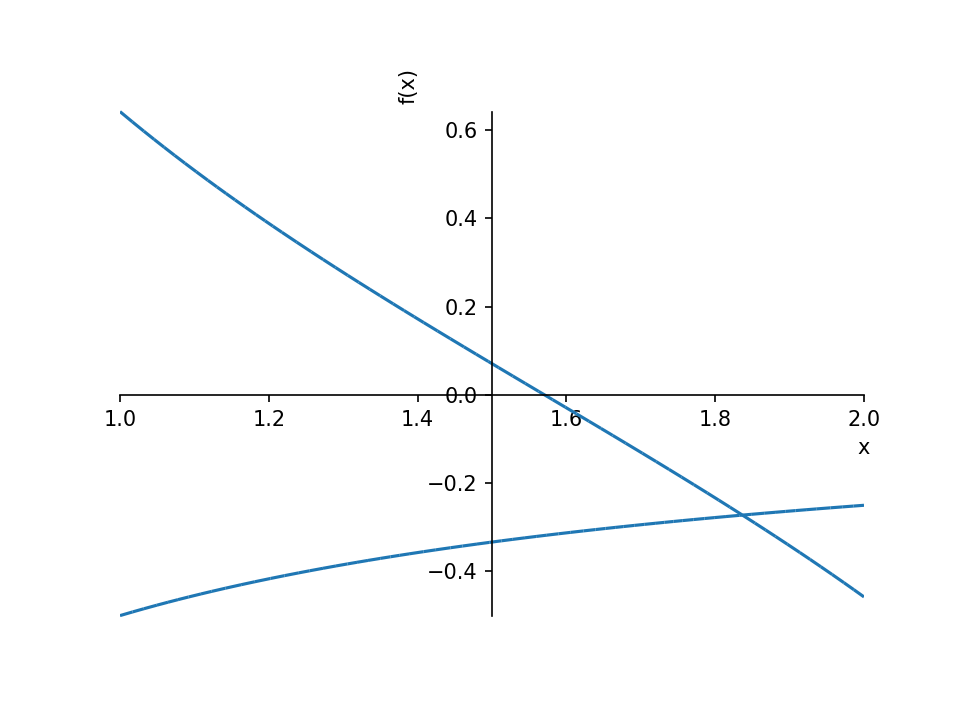

In [29]:
phi = cot(x)
psi = - 1 / (2*x)

plot = sympy.plot(phi, (x, 1, 2), show=False)
p = sympy.plot(psi, (x, 1, 2), show=False)
plot.append(p[0])
plot.show()

fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
fig.show();

In [64]:
a = 1.6
b = 2.0

f = phi - psi
func = lambda val: f.subs(x, val)

In [44]:
print(np.log2((b-a)/2/eps))
print(func(a), func(1.8), func(b))
x_bis = bisection_solve(func, a, b, eps, True)
x_bis, func(x_bis)

10.9657842847
0.283288021800055 0.0444742429237667 -0.207657554360286
 0. a = 1.60000, b = 2.00000, b-a = 0.40000.
 1. a = 1.80000, b = 2.00000, b-a = 0.20000.
 2. a = 1.80000, b = 1.90000, b-a = 0.10000.
 3. a = 1.80000, b = 1.85000, b-a = 0.05000.
 4. a = 1.82500, b = 1.85000, b-a = 0.02500.
 5. a = 1.82500, b = 1.83750, b-a = 0.01250.
 6. a = 1.83125, b = 1.83750, b-a = 0.00625.
 7. a = 1.83438, b = 1.83750, b-a = 0.00313.
 8. a = 1.83594, b = 1.83750, b-a = 0.00156.
 9. a = 1.83594, b = 1.83672, b-a = 0.00078.
10. a = 1.83633, b = 1.83672, b-a = 0.00039.
11. a = 1.83652, b = 1.83672, b-a = 0.00020.


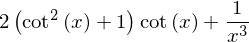

In [45]:
f.diff(x, 2)

In [32]:
func(a), f.diff(x, 2).subs(x, a) # одинаковый знак, поэтому фиксируем левый конец

In [38]:
x_chord = chords_method_solve(func, a, b, 'left', eps, True)
x_chord, func(x_chord)

 1. xₖ = 1.83081, |xₖ-xₖ₋₁| = 0.169190.
 2. xₖ = 1.83672, |xₖ-xₖ₋₁| = 0.005905.
 3. xₖ = 1.83659, |xₖ-xₖ₋₁| = 0.000120.
 4. xₖ = 1.83660, |xₖ-xₖ₋₁| = 0.000003.


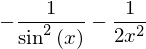

In [81]:
f.diff(x).simplify() # => f'(x) < 0 => рассматриваем исходное уравнение

In [87]:
2 / 13

In [35]:
deriv = lambda val: f.diff(x).subs(x, val)
res1 = minimize_scalar(deriv, bounds=(1.6, 2), method='bounded')
M1 = abs(deriv(res1.x))
neg_deriv = lambda val: -deriv(val)
res2 = minimize_scalar(neg_deriv, bounds=(1.6, 2), method='bounded')
m1 = abs(deriv(res2.x))
m1, M1, 2 / (m1+M1)

In [39]:
x_relax = relaxation_method_solve(func, a, b, 2 / (m1 + M1), eps, True)
x_relax, func(x_relax)

 1. xₖ = 1.83525, |xₖ-xₖ₋₁| = 0.035247.
 2. xₖ = 1.83655, |xₖ-xₖ₋₁| = 0.001308.
 3. xₖ = 1.83660, |xₖ-xₖ₋₁| = 0.000041.


In [40]:
# фиксируем противоположный методу хорд знак
x_newt = newton_method_solve(f, a, b, 'right', eps, True)
x_newt, func(x_newt)

 1. xₖ = 1.836830, |xₖ-xₖ₋₁| = 0.236830.
 2. xₖ = 1.836597, |xₖ-xₖ₋₁| = 0.000233.
 3. xₖ = 1.836597, |xₖ-xₖ₋₁| = 0.000000.


In [41]:
# фиксируем, с какой стороны будет находиться последовательность метода Ньютона
x_comb = combined_chord_newton_solve(f, a, b, 'left', eps, True)
x_comb, func(x_comb)

 0. x_newt = 1.836830, x_chord = 1.830810, |x_newt - x_chord| =  0.0060199.
 1. x_newt = 1.836597, x_chord = 1.836597, |x_newt - x_chord| =  0.0000002.


In [42]:
# фиксируем тот же конец, что и в методе Ньютона
x_sec = secant_method_solve(func, a, b, 'right', 0.1, eps, True)
x_sec, func(x_sec)

 1. xₖ = 1.83420, |xₖ-xₖ₋₁| = 0.234199.
 2. xₖ = 1.83665, |xₖ-xₖ₋₁| = 0.002447.
 3. xₖ = 1.83660, |xₖ-xₖ₋₁| = 0.000050.


In [ ]:
"""
    Решает уравнение 'func(x) == 0' методом хорд. 
    Возвращает один из корней.
    Вызывающий код должен гарантировать выполнение необходимых 
    предположений (в частности, что хотя бы в одном конце отрезка
    знак второй производной совпадает со знаком функции)
    
    Параметры
    ----------
    func : callable
        функция, корни которой необходимо найти
    left, right : float
        концы отрезка, в котором ищется корень
    fixed : 'left' | 'right'
        какой из концов отрезка фиксируется
    eps : float
        точность
    
    Возвращаемое значение
    -------
    x0 : float
        корень уравнения с точностью до eps
    """

In [ ]:
def plot_coord_system(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

In [ ]:
def chords_method_solve(func, left, right, fixed, eps, axes=None):
    
    if fixed == 'left':
        c = left
        x_curr = right
    elif fixed == 'right': 
        c = right
        x_curr = left
    else:
        raise ValueError("Inappropriate value for argument 'fixed'!")
    
    if axes is not None:
        x_grid = np.linspace(left, right, 1001)
        axes.plot(x_grid, list(map(func, x_grid)))
        l = plt.Line2D([c, x_curr], [func(c), func(x_curr)])
        axes.grid(alpha=0.5)
        axes.add_line(l)
        plot_coord_system(axes)
        plt.show()
    
    while True:
        x_next = x_curr - func(x_curr) * (x_curr - c) / (func(x_curr) - func(c))
        if abs(x_next - x_curr) <= eps:
            return x_next
        x_curr = x_next
        if axes is not None:
            time.sleep(2)
            l.set_xdata([c, x_curr])
            l.set_ydata([func(c), func(x_curr)])
            plt.show()